In [26]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import sys
sys.path.append('./source')
import mgc_adversary
import mgc_classifier
import dataset_loader as datasets


In [3]:
from importlib import reload

mgc_adversary = reload(mgc_adversary)
mgc_classifier = reload(mgc_classifier)
dataset_loader = reload(dataset_loader)

In [96]:
from IPython.display import clear_output
class train_and_validate_adversarial:
    """
    class that implements training the network and
    outputting validation metrics
    """

    def __init__(
        self, model, datapath, criterion, optimizer, lrs, batch_size, minibatch_size,
        num_workers, scheduler,
    ):

        # choose gpu or cpu
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # initialize the model
        self.model = model(
            out_channels=1, 
            num_conv_layers=5, 
            n_classes=40, 
            img_size=128
        ).to(self.device)
        self.datapath = datapath
        self.optimizer = optimizer(self.model.parameters(), lr=lrs[1])
        self.criterion = criterion.to(self.device)
        self.scheduler = scheduler(
            self.optimizer, 
            base_lr=lrs[0], 
            max_lr=lrs[2],
            cycle_momentum=False
        )

        # hyperparameters
        self.batch_size = batch_size
        self.minibatch_size = minibatch_size
        self.num_workers = num_workers

        # initialize the logging variables
        self.training_loss = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.class_accuracy = np.zeros(40)

        # training and validation dataloaders
        self.train_ratio = 0.99
        self.train_dataloader = None
        self.validation_dataloader = None

    def train(self, epochs=3):
        """
        train the network
        """
        
        
        # get the full dataset in the folder
        folder_dataset = datasets.PklDataset(self.datapath)
        print(len(folder_dataset))

        # split data into training and test

        train_data, validation_data = torch.utils.data.random_split(
            dataset=folder_dataset,
            lengths=[
                int(len(folder_dataset) * self.train_ratio),
                len(folder_dataset) - int(len(folder_dataset) * self.train_ratio),
            ],
        )
        print(len(train_data))

        # get the DataLoaders
        self.train_dataloader = DataLoader(dataset = train_data,
            batch_size = self.batch_size,
            shuffle = True, 
            num_workers = self.num_workers,
            collate_fn = datasets.PklDataset.collate_fn,
        )
        self.validation_dataloader = DataLoader(dataset = validation_data,
            batch_size = self.batch_size,
            shuffle = True, 
            num_workers = self.num_workers,
            collate_fn = datasets.PklDataset.collate_fn,
        )
        
        for epoch in range(10):
            # initialize the training loss averaging list
            temp_loss = []
            # iterate through the samples
            ii = 0
            for i, batch_sample in enumerate(self.train_dataloader):
                minibatch = datasets.MinibatchDataset(
                    data = batch_sample,
                )
                minibatch_dataloader = DataLoader(
                    dataset = minibatch,
                    batch_size = self.minibatch_size,
                    shuffle = True,
                    pin_memory=True,
                )
                self.optimizer.zero_grad()
                for inputs, targets in minibatch_dataloader:

                    # send minibatch to gpu or cpu
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    # forward pass
                    predictions = self.model(inputs)
                    
                    # loss 
                    loss = self.criterion(predictions, targets)
                    

                    # backward step
                    loss.backward()
                    
                    self.optimizer.step()
                    self.scheduler.step()

                    self.training_loss.append(loss.item())
                    
                    print(f'\r{i} {ii}', end = '')
                    ii+=1
                    
                        
                if i%30 == 0:
                    self.validate()
                if i%30 == 0 and i!=0:
                    moving_average_over = 200
                    moving_window = -(100)
                    if len(self.training_loss)<moving_window:
                        moving_window=0
                    clear_output(wait=True)
                    # initialize figure for plotting
                    fig, axs = plt.subplots(nrows=3, ncols=1)
                    fig.set_size_inches(8.5, 10.5)
                    axs[0].plot(moving_average(self.training_loss, 200))
                    axs[0].legend(['train loss'])
                    axs[1].plot(self.validation_loss[moving_window:], 'orange')
                    axs[1].legend(['val_loss'])
                    ax1t = axs[1].twinx()
                    ax1t.plot(self.validation_accuracy[moving_window:], 'g')
                    ax1t.legend(['val acc'], loc=0)
                    axs[2].bar(
                        x = datasets.PklDataset(0).categories,
                        height = self.class_accuracy
                    ) 
                    axs[2].axhline(y=0.01, color='r', linestyle='-')
                    axs[2].tick_params(axis='x', labelrotation=90)      
                    plt.pause(0.0001)
#                 if len(self.validation_loss)>10:
#                     if self.validation_loss[-1]<self.validation_loss[-2]:
#                         torch.save(
#                             self.model.state_dict(), 
#                             Path("./drive/MyDrive/models/StaticMgcClassifier.pkl")
#                         )
                
  
    def validate(self):
        """
        validate the network predictions
        """
        with torch.no_grad():
            # initalize list to average the accuracy
            # and loss over the validation dataset
            loss_temp = []
            accuracy_temp = []
            prediction_class_sum = np.zeros(40)
            class_accuracy_temp = []
            for i, batch_sample in enumerate(self.validation_dataloader):
                minibatch = datasets.MinibatchDataset(
                    data = batch_sample,
                )
                minibatch_dataloader = DataLoader(
                    dataset = minibatch,
                    batch_size = self.minibatch_size,
                    shuffle = True,
                    pin_memory=True,
                )
                for inputs, targets in minibatch_dataloader:

                    # send minibatch to gpu or cpu
                    inputs = inputs.to(self.device)
                    targets = targets

                    # run prediction on a subset of the data
                    predictions = self.model(inputs)
                    predictions = predictions.cpu()

                    # get validation loss
                    loss_temp.append(self.criterion(predictions, targets).numpy().item())

                    # get validation accuracy
                    for j in range(predictions.shape[0]):
                        tgts = targets[j, :]
                        preds = predictions[j, :]
                        k = int(torch.sum(tgts))
                        prediction_topk = torch.topk(preds, k=k).indices
                        prediction_classes = torch.zeros_like(preds)
                        prediction_classes[prediction_topk] = 1.0
                        number_correct_classes = torch.sum(torch.logical_and(tgts, prediction_classes))
                        accuracy_temp.append((number_correct_classes/k).numpy().item())
                        class_accuracy_temp.append(torch.logical_and(tgts, prediction_classes).float().numpy())

            class_accuracy_temp=np.array(class_accuracy_temp)
            self.class_accuracy = np.sum(class_accuracy_temp, axis=0)/class_accuracy_temp.shape[0]
            self.validation_accuracy.append(np.mean(accuracy_temp))
            self.validation_loss.append(np.mean(loss_temp))
            
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

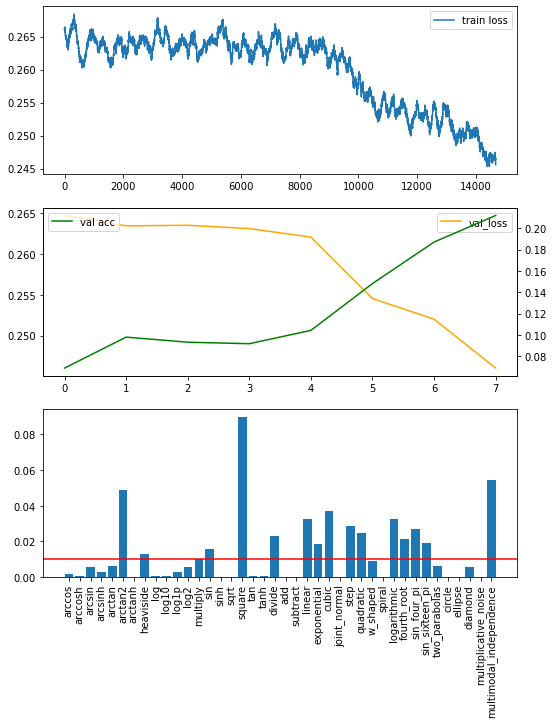

60 4700

In [ ]:
test_model = mgc_classifier.MgcNet

root_path = Path("./data")
train_val_object = train_and_validate_adversarial(
    model=mgc_classifier.MgcNet,
    datapath=root_path,
    criterion=torch.nn.BCELoss(),
    optimizer=torch.optim.Adam,
    scheduler=torch.optim.lr_scheduler.CyclicLR,
    lrs=[1e-8, 1e-5, 1e-5],
    batch_size=15,  # just how much data can be loaded into memory at one time
    minibatch_size=16,  # what actually controls the batching size for training
    num_workers=2,
)

train_val_object.train()